In [1]:
from glob import glob
from os.path import join
import pandas as pd

In [2]:
import numpy as np
import pickle

def load_pickle_safely(pickle_file):
    with open(pickle_file, 'rb') as f:
        return pickle.load(f)

def maybe_load_pickle(pickle_file):
    try:
        result = load_pickle_safely(pickle_file)
    except Exception:
        return None

def compute_means(draw_dict):
    
    return {x: y.mean(axis=(0, 1)) for x, y in draw_dict.items()}

def compute_sds(draw_dict):
    
    return {x: y.std(axis=(0, 1)) for x, y in draw_dict.items()}

def compute_z_score_mean(mean_dict, ref_mean_dict, ref_sd_dict):
    
    return {x: (mean_dict[x] - ref_mean_dict[x]) / ref_sd_dict[x] for x in mean_dict}

def compute_relative_error_sd(sd_dict, ref_sd_dict):

    return {x: (sd_dict[x] - ref_sd_dict[x]) / ref_sd_dict[x] for x in ref_sd_dict}

def flatten_dict(var_dict, names):

    return np.concatenate([var_dict[x].reshape(-1) for x in names])


In [5]:
from os.path import split, splitext

def load_moment_df(draw_folder):

    model_dicts = glob(join(draw_folder, "draw_dicts", "*.npz"))
    data = pd.DataFrame({"draw_dict_path": model_dicts})

    data["draws"] = data["draw_dict_path"].apply(lambda x: dict(np.load(x)))
    data["means"] = data["draws"].apply(compute_means)
    data["sds"] = data["draws"].apply(compute_sds)

    # No need for the draws any more for now
    data = data.drop(columns="draws")

    # Fetch model name
    data['model_name'] = data['draw_dict_path'].apply(lambda x: splitext(split(x)[-1])[0])

    return data

def check_convergence_sadvi(metadata, max_iter=100000):

    return metadata['steps'] < max_iter


def check_convergence_raabbvi(metadata, max_iter=19900):

    n_steps = metadata['kl_hist_i'].max()

    return n_steps < max_iter


def add_metadata(moment_df, method):

    assert method in ['NUTS', 'RAABBVI', 'DADVI', 'LRVB', 'SADVI', 'SADVI_FR', 'LRVB_Doubling']

    if method in ['RAABBVI', 'DADVI', 'LRVB', 'SADVI', 'SADVI_FR', 'LRVB_Doubling']:
        subdir_lookup = {
            'RAABBVI': 'info',
            'DADVI': 'dadvi_info',
            'LRVB': 'lrvb_info',
            'SADVI': 'info',
            'SADVI_FR': 'info',
            'LRVB_Doubling': 'lrvb_info'
        }
        subdir = subdir_lookup[method]
        moment_df["info_path"] = (
            moment_df["draw_dict_path"]
            .str.replace("draw_dicts", subdir)
            .str.replace(".npz", ".pkl", regex=False)
        )

        moment_df['metadata'] = moment_df['info_path'].apply(load_pickle_safely)
        moment_df['runtime'] = moment_df['metadata'].apply(lambda x: x['runtime'])

        if method.startswith('SADVI'):
            moment_df['converged'] = moment_df['metadata'].apply(check_convergence_sadvi)
        elif method == 'RAABBVI':
            moment_df['converged'] = moment_df['metadata'].apply(check_convergence_raabbvi)

    else:
        # It's NUTS; get runtime:
        moment_df['runtime_path'] = (
            moment_df['draw_dict_path']
            .str.replace('draw_dicts', 'runtimes')
            .str.replace('.npz', '.csv', regex=False)
        )
        moment_df['runtime'] = (
            moment_df['runtime_path']
            .apply(lambda x: pd.read_csv(x)['0'].iloc[0])
        )

        # TODO: get rhat

    return moment_df

from os.path import join

#base_folder = '../blade_runs/'
base_folder = '/media/martin/External Drive/projects/lrvb_paper/dadvi_runs_october_2022'

folder_method_list = (
    (join(base_folder, "nuts_results/"), 'NUTS'),
    (join(base_folder, "dadvi_results/"), 'DADVI'),
    (join(base_folder, "lrvb_results/"), 'LRVB'),
    (join(base_folder, "raabbvi_results/"), 'RAABBVI'),
    (join(base_folder, "sadvi_results/"), 'SADVI'),
    (join(base_folder, "sfullrank_advi_results/"), 'SADVI_FR'),
    (join(base_folder, 'lrvb_doubling_results'), 'LRVB_Doubling')
)

all_results = dict()

for cur_folder, cur_method in folder_method_list:

    print(cur_method, cur_folder)

    data = load_moment_df(cur_folder)

    data = add_metadata(data, cur_method)

    all_results[cur_method] = data


NUTS /media/martin/External Drive/projects/lrvb_paper/dadvi_runs_october_2022/nuts_results/
DADVI /media/martin/External Drive/projects/lrvb_paper/dadvi_runs_october_2022/dadvi_results/


LRVB /media/martin/External Drive/projects/lrvb_paper/dadvi_runs_october_2022/lrvb_results/
RAABBVI /media/martin/External Drive/projects/lrvb_paper/dadvi_runs_october_2022/raabbvi_results/
SADVI /media/martin/External Drive/projects/lrvb_paper/dadvi_runs_october_2022/sadvi_results/
SADVI_FR /media/martin/External Drive/projects/lrvb_paper/dadvi_runs_october_2022/sfullrank_advi_results/
LRVB_Doubling /media/martin/External Drive/projects/lrvb_paper/dadvi_runs_october_2022/lrvb_doubling_results


In [6]:
def add_deviation_stats(model_df, reference_df):

    together = model_df.merge(
        reference_df, on="model_name", suffixes=("_model", "_reference")
    )

    together["mean_deviations"] = together.apply(
        lambda x: compute_z_score_mean(
            x["means_model"], x["means_reference"], x["sds_reference"]
        ),
        axis=1,
    )

    together["sd_deviations"] = together.apply(
        lambda x: compute_relative_error_sd(x["sds_model"], x["sds_reference"]), axis=1
    )

    together["var_names"] = together["means_reference"].apply(
        lambda x: sorted(list(x.keys()))
    )


    # Add these to the model stats
    cols_to_keep = [
        "model_name",
        "mean_deviations",
        "sd_deviations",
        "var_names",
    ]

    new_stats = together[cols_to_keep]

    return model_df.merge(new_stats, on='model_name', how='left')


def add_derived_stats(model_df):

    model_df["mean_deviations_flat"] = model_df.apply(
        lambda x: flatten_dict(x["mean_deviations"], x["var_names"]), axis=1
    )

    model_df["sd_deviations_flat"] = model_df.apply(
        lambda x: flatten_dict(x["sd_deviations"], x["var_names"]), axis=1
    )

    model_df['mean_rms'] = model_df['mean_deviations_flat'].apply(lambda x: np.sqrt(np.mean(x**2)))
    model_df['sd_rms'] = model_df['sd_deviations_flat'].apply(lambda x: np.sqrt(np.mean(x**2)))

    return model_df


In [7]:
all_results['SADVI']

,draw_dict_path,means,sds,model_name,info_path,metadata,runtime,converged
0,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 0.3367091931756018, 'c_dist100':...","{'Intercept': 0.04064973521120831, 'c_dist100'...",wells_dae_inter_c,/media/martin/External Drive/projects/lrvb_pap...,"{'steps': 100000, 'runtime': 32.270623207092285}",32.270623,False
1,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 1.2265846521369745, 'x': [-0.617...","{'Intercept': 0.031655995599598086, 'x': [0.08...",radon_complete_pool,/media/martin/External Drive/projects/lrvb_pap...,"{'steps': 46599, 'runtime': 6.105165481567383}",6.105165,True
2,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 0.15500817492108865, 'black': [-...","{'Intercept': 0.022073035691288132, 'black': [...",election88_full,/media/martin/External Drive/projects/lrvb_pap...,"{'steps': 100000, 'runtime': 113.4734456539154}",113.473446,False
3,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 0.33749558291227777, 'c_dist100'...","{'Intercept': 0.04229211766939031, 'c_dist100'...",wells_interaction_c,/media/martin/External Drive/projects/lrvb_pap...,"{'steps': 100000, 'runtime': 29.94301962852478}",29.943020,False
4,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 97.13495355451238, 'treatment': ...","{'Intercept': 0.4869058606453857, 'treatment':...",electric_1b,/media/martin/External Drive/projects/lrvb_pap...,"{'steps': 100000, 'runtime': 13.98698091506958}",13.986981,False
...,...,...,...,...,...,...,...,...
61,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 26.72985845472546, 'encouraged':...","{'Intercept': 1.0099293284691508, 'encouraged'...",sesame_one_pred_b,/media/martin/External Drive/projects/lrvb_pap...,"{'steps': 36399, 'runtime': 4.864454984664917}",4.864455,True
62,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 97.13727261916551, 'treatment': ...","{'Intercept': 0.7010511198636057, 'treatment':...",electric,/media/martin/External Drive/projects/lrvb_pap...,"{'steps': 100000, 'runtime': 13.60534143447876}",13.605341,False
63,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 26.73243525389878, 'watched_hat'...","{'Intercept': 0.7232151195729432, 'watched_hat...",sesame_multi_preds_3b,/media/martin/External Drive/projects/lrvb_pap...,"{'steps': 100000, 'runtime': 12.623547077178955}",12.623547,False
64,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': -2.4359805481499963, 'x': [2.837...","{'Intercept': 0.5451346095515625, 'x': [0.5102...",separation,/media/martin/External Drive/projects/lrvb_pap...,"{'steps': 25299, 'runtime': 3.7067837715148926}",3.706784,True


In [18]:
raabbvi_maxiter = 19900

method_1 = 'DADVI'
method_2 = 'RAABBVI'

method_1_df = add_deviation_stats(all_results[method_1], all_results['NUTS']).dropna()
method_1_df = add_derived_stats(method_1_df)

method_2_df = add_deviation_stats(all_results[method_2], all_results['NUTS']).dropna()
method_2_df = add_derived_stats(method_2_df)


/tmp/ipykernel_1179554/975127475.py:24: RuntimeWarning: invalid value encountered in true_divide
  return {x: (mean_dict[x] - ref_mean_dict[x]) / ref_sd_dict[x] for x in mean_dict}
/tmp/ipykernel_1179554/975127475.py:28: RuntimeWarning: invalid value encountered in true_divide
  return {x: (sd_dict[x] - ref_sd_dict[x]) / ref_sd_dict[x] for x in ref_sd_dict}
/tmp/ipykernel_1179554/975127475.py:24: RuntimeWarning: invalid value encountered in true_divide
  return {x: (mean_dict[x] - ref_mean_dict[x]) / ref_sd_dict[x] for x in mean_dict}
/tmp/ipykernel_1179554/975127475.py:28: RuntimeWarning: invalid value encountered in true_divide
  return {x: (sd_dict[x] - ref_sd_dict[x]) / ref_sd_dict[x] for x in ref_sd_dict}


In [19]:
all_results['SADVI']['converged'].mean()

0.24242424242424243

In [20]:
comparison = method_1_df.merge(method_2_df, on='model_name', 
                                         suffixes=(f'_{method_1}', f'_{method_2}'))

comparison

,draw_dict_path_DADVI,means_DADVI,sds_DADVI,model_name,info_path_DADVI,metadata_DADVI,runtime_DADVI,mean_deviations_DADVI,sd_deviations_DADVI,var_names_DADVI,...,metadata_RAABBVI,runtime_RAABBVI,converged,mean_deviations_RAABBVI,sd_deviations_RAABBVI,var_names_RAABBVI,mean_deviations_flat_RAABBVI,sd_deviations_flat_RAABBVI,mean_rms_RAABBVI,sd_rms_RAABBVI
0,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 0.33795310304035997, 'c_dist100'...","{'Intercept': 0.030490049797417394, 'c_dist100...",wells_dae_inter_c,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [ 0.338753...,1.454596,"{'Intercept': -0.12912341642813885, 'c_dist100...","{'Intercept': -0.19829007443187366, 'c_dist100...","[Intercept, c_arsenic, c_arsenic:c_educ4, c_di...",...,"{'opt_result': [0.34244034420039937, 0.4972047...",64.792155,True,"{'Intercept': -0.030136407180841405, 'c_dist10...","{'Intercept': -0.0063621019357891035, 'c_dist1...","[Intercept, c_arsenic, c_arsenic:c_educ4, c_di...","[-0.030136407180841405, -0.0344771211007467, 0...","[-0.0063621019357891035, -0.039108626219445275...",0.031680,0.047814
1,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 1.2238588397341919, 'x': [-0.592...","{'Intercept': 0.0360937900729387, 'x': [0.0648...",radon_complete_pool,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [ 1.225699...,0.989881,"{'Intercept': -0.028480444707208168, 'x': [0.2...","{'Intercept': 0.3306631893382925, 'x': [-0.107...","[Intercept, x, y_sigma]",...,"{'opt_result': [1.2246182903873999, -0.6135075...",10.743379,True,"{'Intercept': -0.05262309424970235, 'x': [-0.0...","{'Intercept': 0.017319461080812237, 'x': [-0.0...","[Intercept, x, y_sigma]","[-0.05262309424970235, -0.05282731329243913, 0...","[0.017319461080812237, -0.009670925346132654, ...",0.046288,0.013325
2,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 0.14719523070695312, 'black': [-...","{'Intercept': 0.03049705565736079, 'black': [0...",election88_full,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [ 9.628479...,5.383657,"{'Intercept': 0.18494210939749467, 'black': [-...","{'Intercept': -0.9095886954239918, 'black': [-...","[1|age, 1|age_edu, 1|age_edu_offset, 1|age_edu...",...,"{'opt_result': [0.2214337767393307, 1.34836886...",589.771108,False,"{'Intercept': 0.20224792485913157, 'black': [-...","{'Intercept': -0.9411061130269064, 'black': [-...","[1|age, 1|age_edu, 1|age_edu_offset, 1|age_edu...","[-0.5849695793779083, -0.5828058700693367, 0.5...","[-0.9979773925309029, -0.9959047735561799, -0....",0.483358,0.690491
3,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 0.3609467582302399, 'c_dist100':...","{'Intercept': 0.0438726657493569, 'c_dist100':...",wells_interaction_c,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [ 0.359509...,1.067712,"{'Intercept': 0.5692040360039159, 'c_dist100':...","{'Intercept': 0.1350620326338521, 'c_dist100':...","[Intercept, c_arsenic, c_dist100, c_dist100:c_...",...,"{'opt_result': [0.338000134118629, 0.470835724...",65.092864,True,"{'Intercept': -0.006361784242704517, 'c_dist10...","{'Intercept': 0.03270626318315567, 'c_dist100'...","[Intercept, c_arsenic, c_dist100, c_dist100:c_...","[-0.006361784242704517, -0.10261832026345656, ...","[0.03270626318315567, -0.08710444941079848, -0...",0.062757,0.055376
4,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 97.18493078848319, 'treatment': ...","{'Intercept': 0.4192980428127236, 'treatment':...",electric_1b,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [-2.227039...,1.715874,"{'Intercept': 0.013862321044975017, 'treatment...","{'Intercept': -0.42814149433345, 'treatment': ...","[1|pair, 1|pair_offset, 1|pair_sigma, Intercep...",...,"{'opt_result': [0.9999703086376698, 1.15956376...",40.200612,False,"{'Intercept': -92.94557840902398,

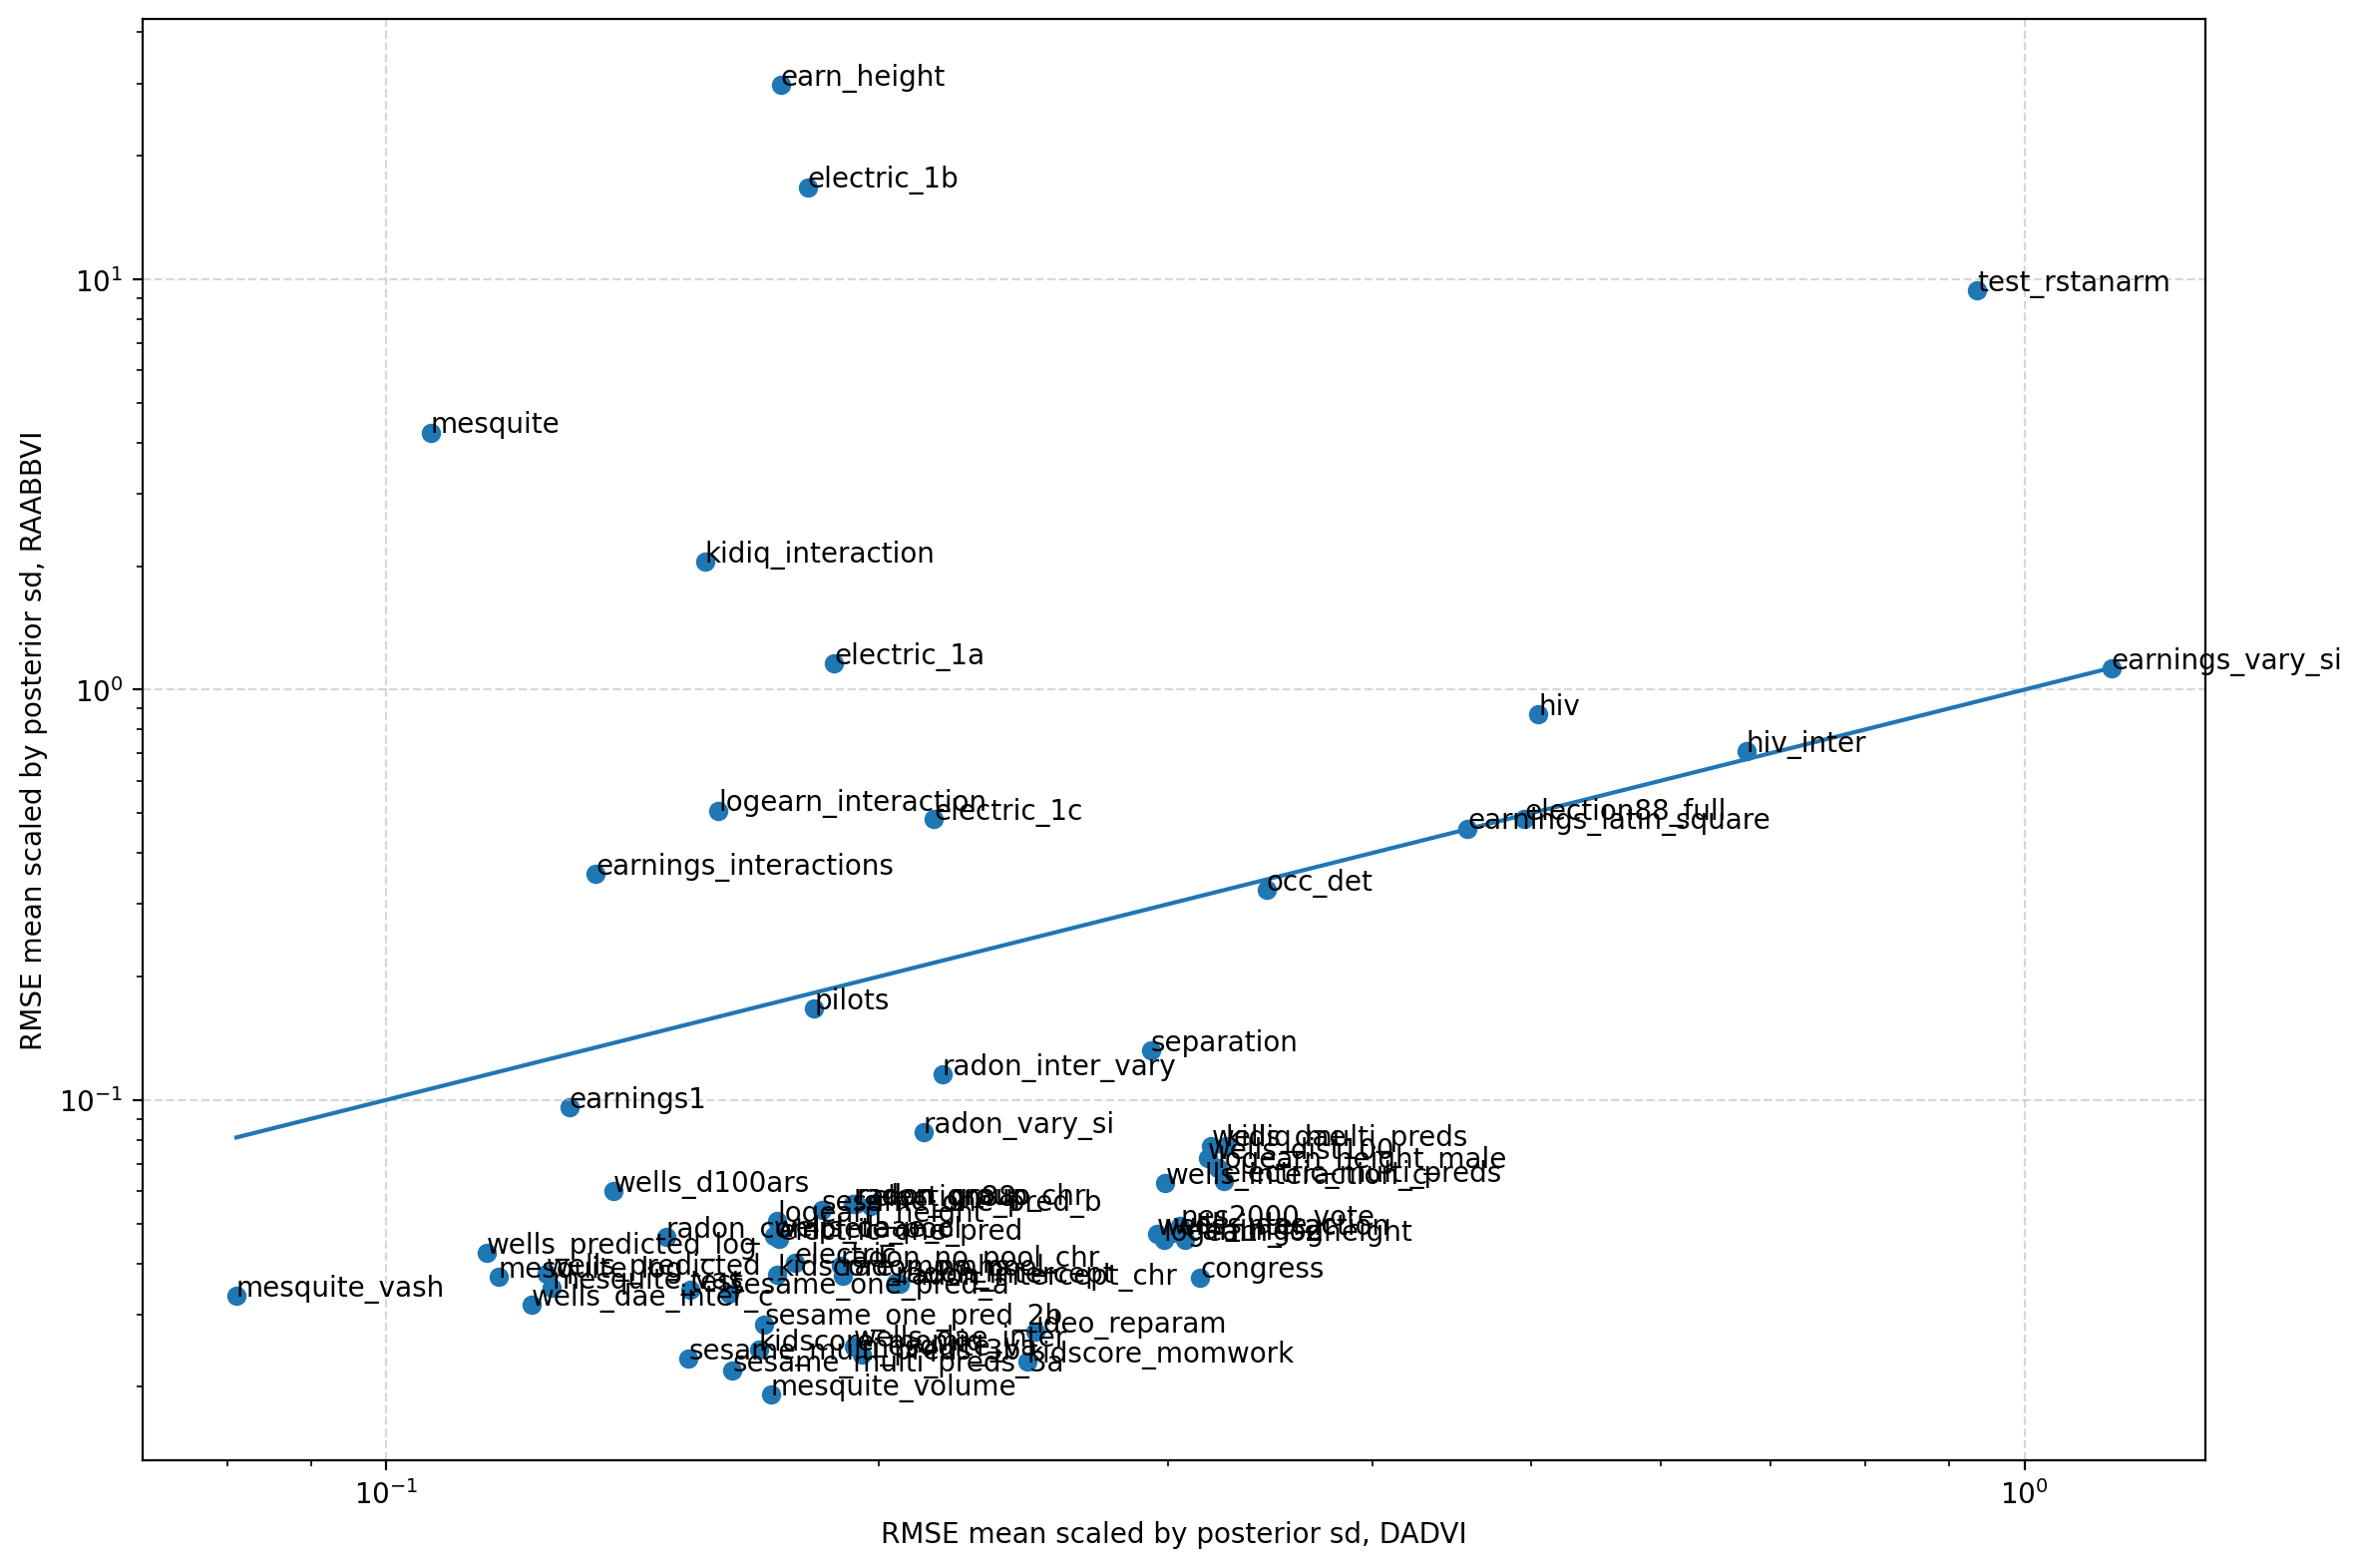

In [21]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison[f'mean_rms_{method_1}'].min(), comparison[f'mean_rms_{method_1}'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison[f'mean_rms_{method_1}'], comparison[f'mean_rms_{method_2}'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (getattr(row, f'mean_rms_{method_1}'), getattr(row, f'mean_rms_{method_2}')))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'RMSE mean scaled by posterior sd, {method_1}')
ax.set_ylabel(f'RMSE mean scaled by posterior sd, {method_2}')

ax.grid(alpha=0.5, linestyle='--')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('./mean_comparison.png', dpi=300)


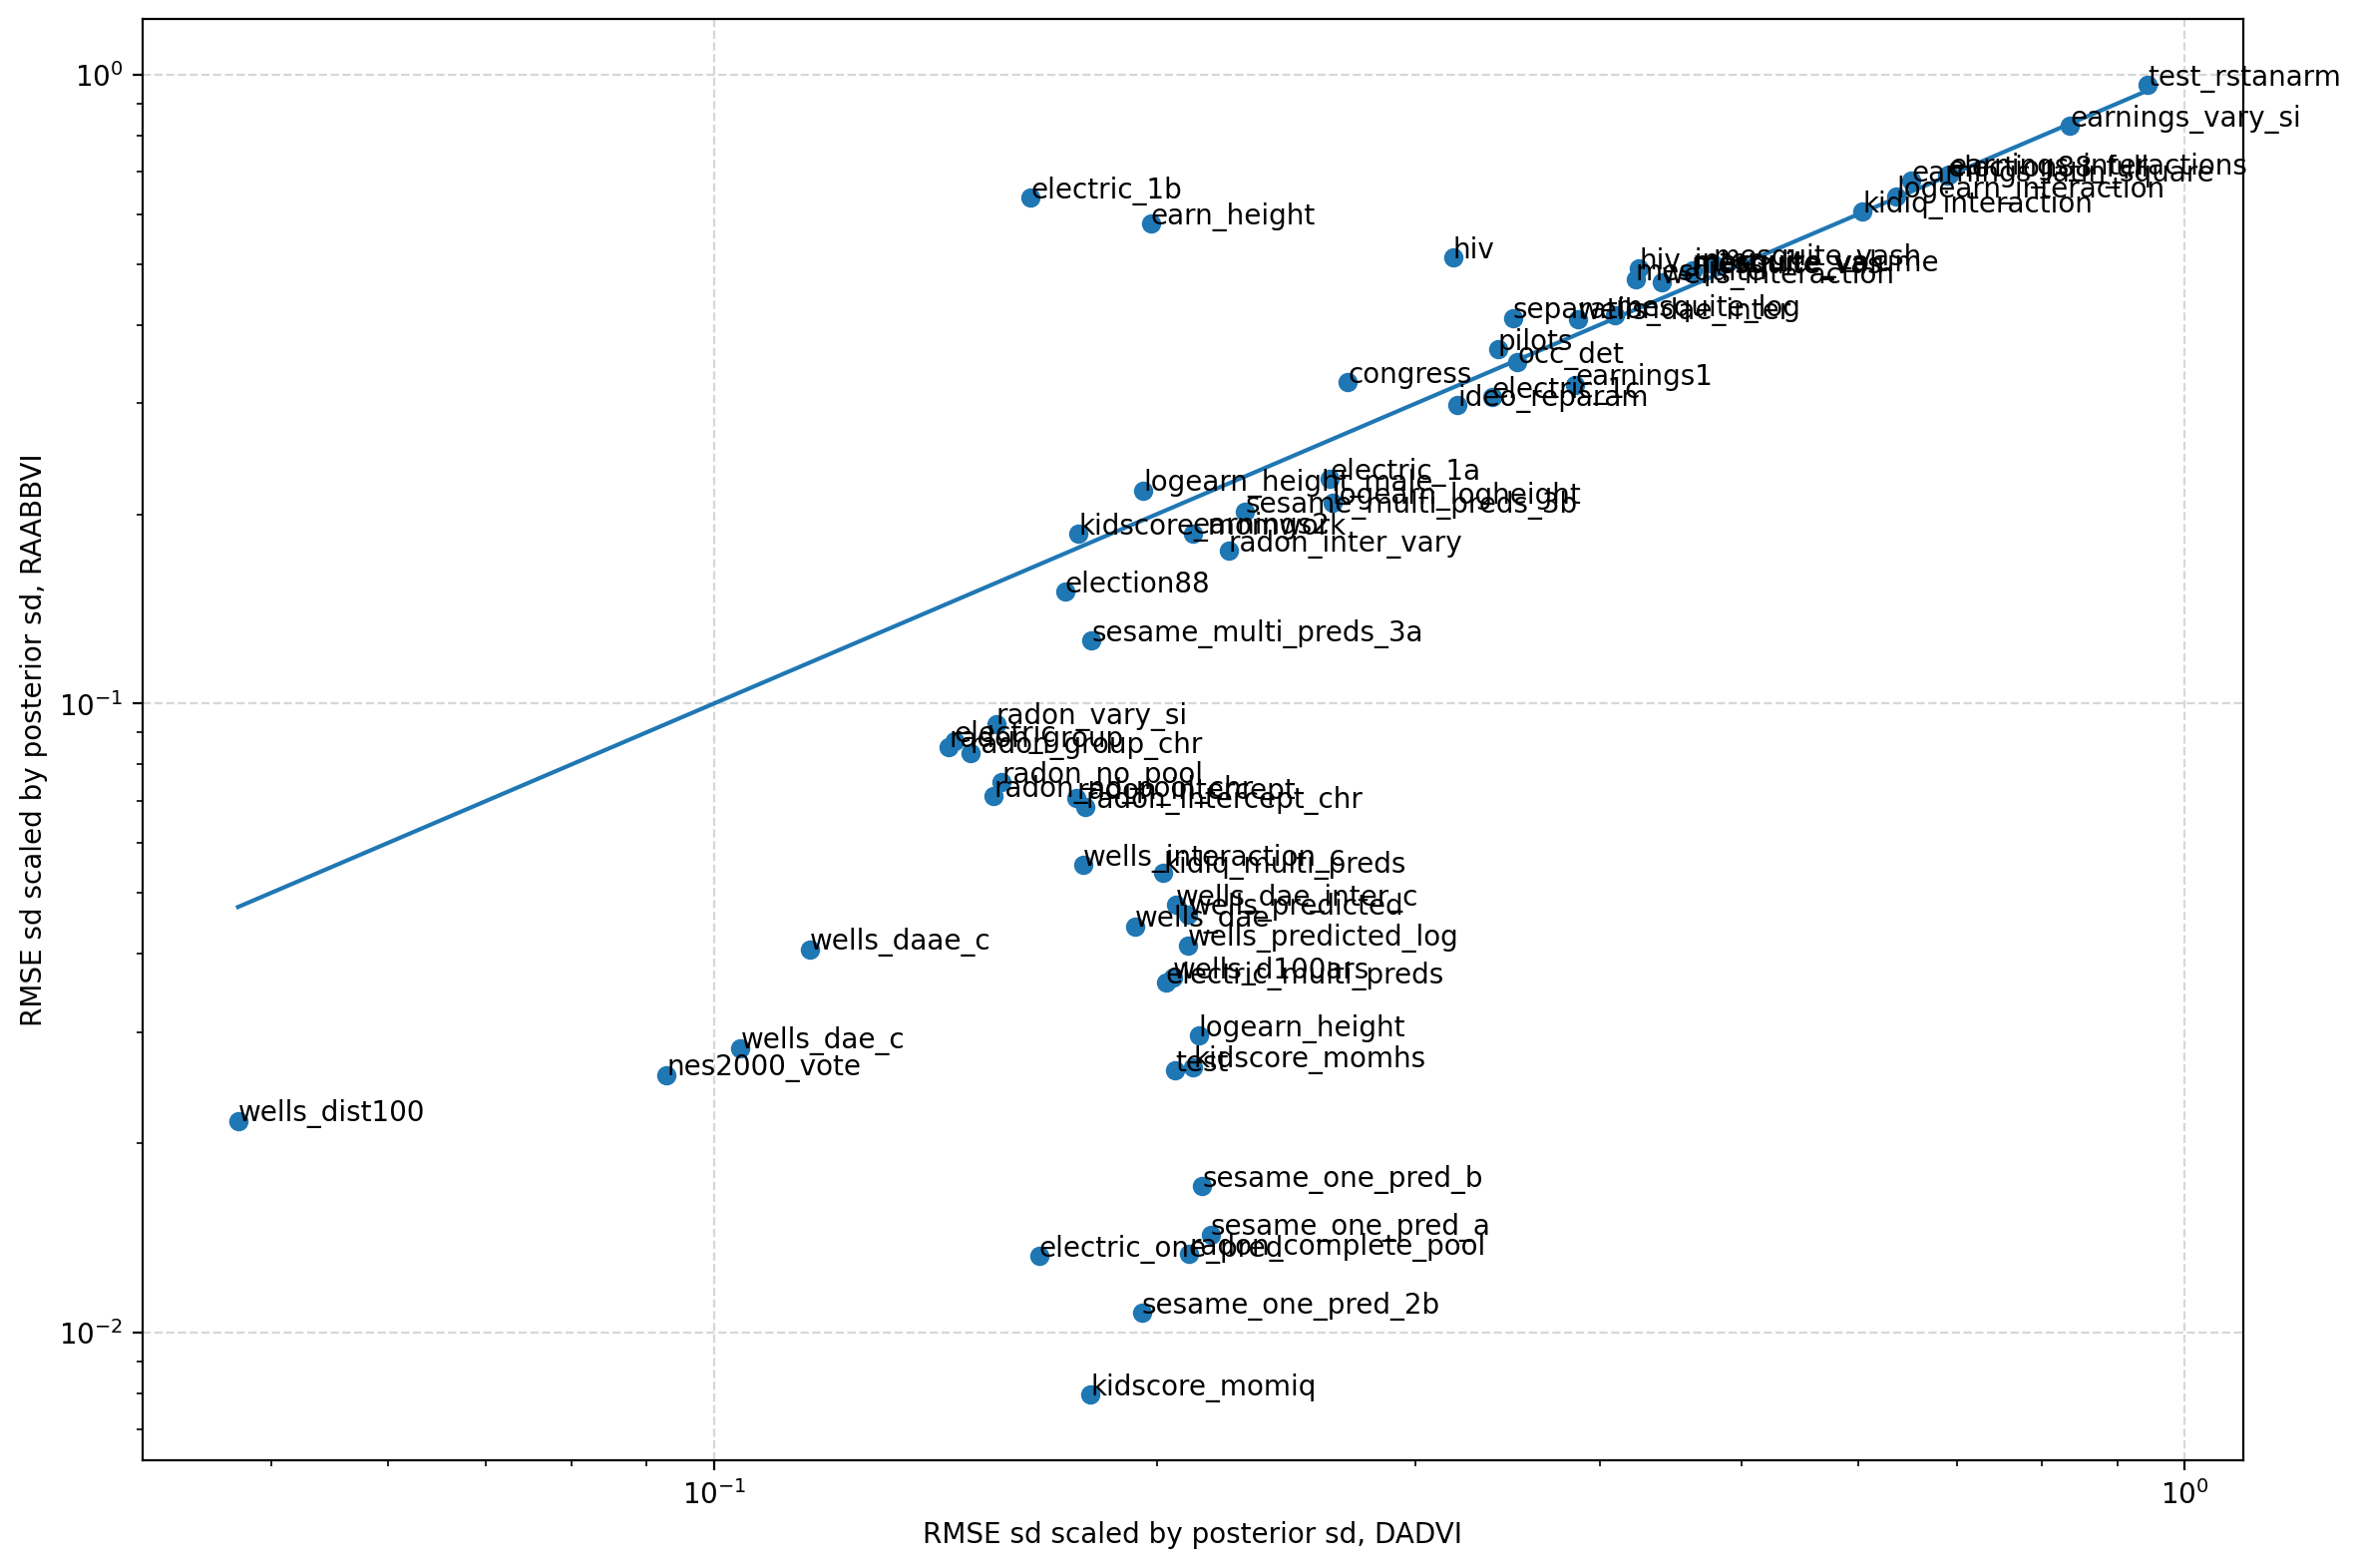

In [22]:
f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison[f'sd_rms_{method_1}'].min(), comparison[f'sd_rms_{method_1}'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison[f'sd_rms_{method_1}'], comparison[f'sd_rms_{method_2}'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (getattr(row, f'sd_rms_{method_1}'), getattr(row, f'sd_rms_{method_2}')))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'RMSE sd scaled by posterior sd, {method_1}')
ax.set_ylabel(f'RMSE sd scaled by posterior sd, {method_2}')

ax.grid(alpha=0.5, linestyle='--')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('./sd_comparison.png', dpi=300)

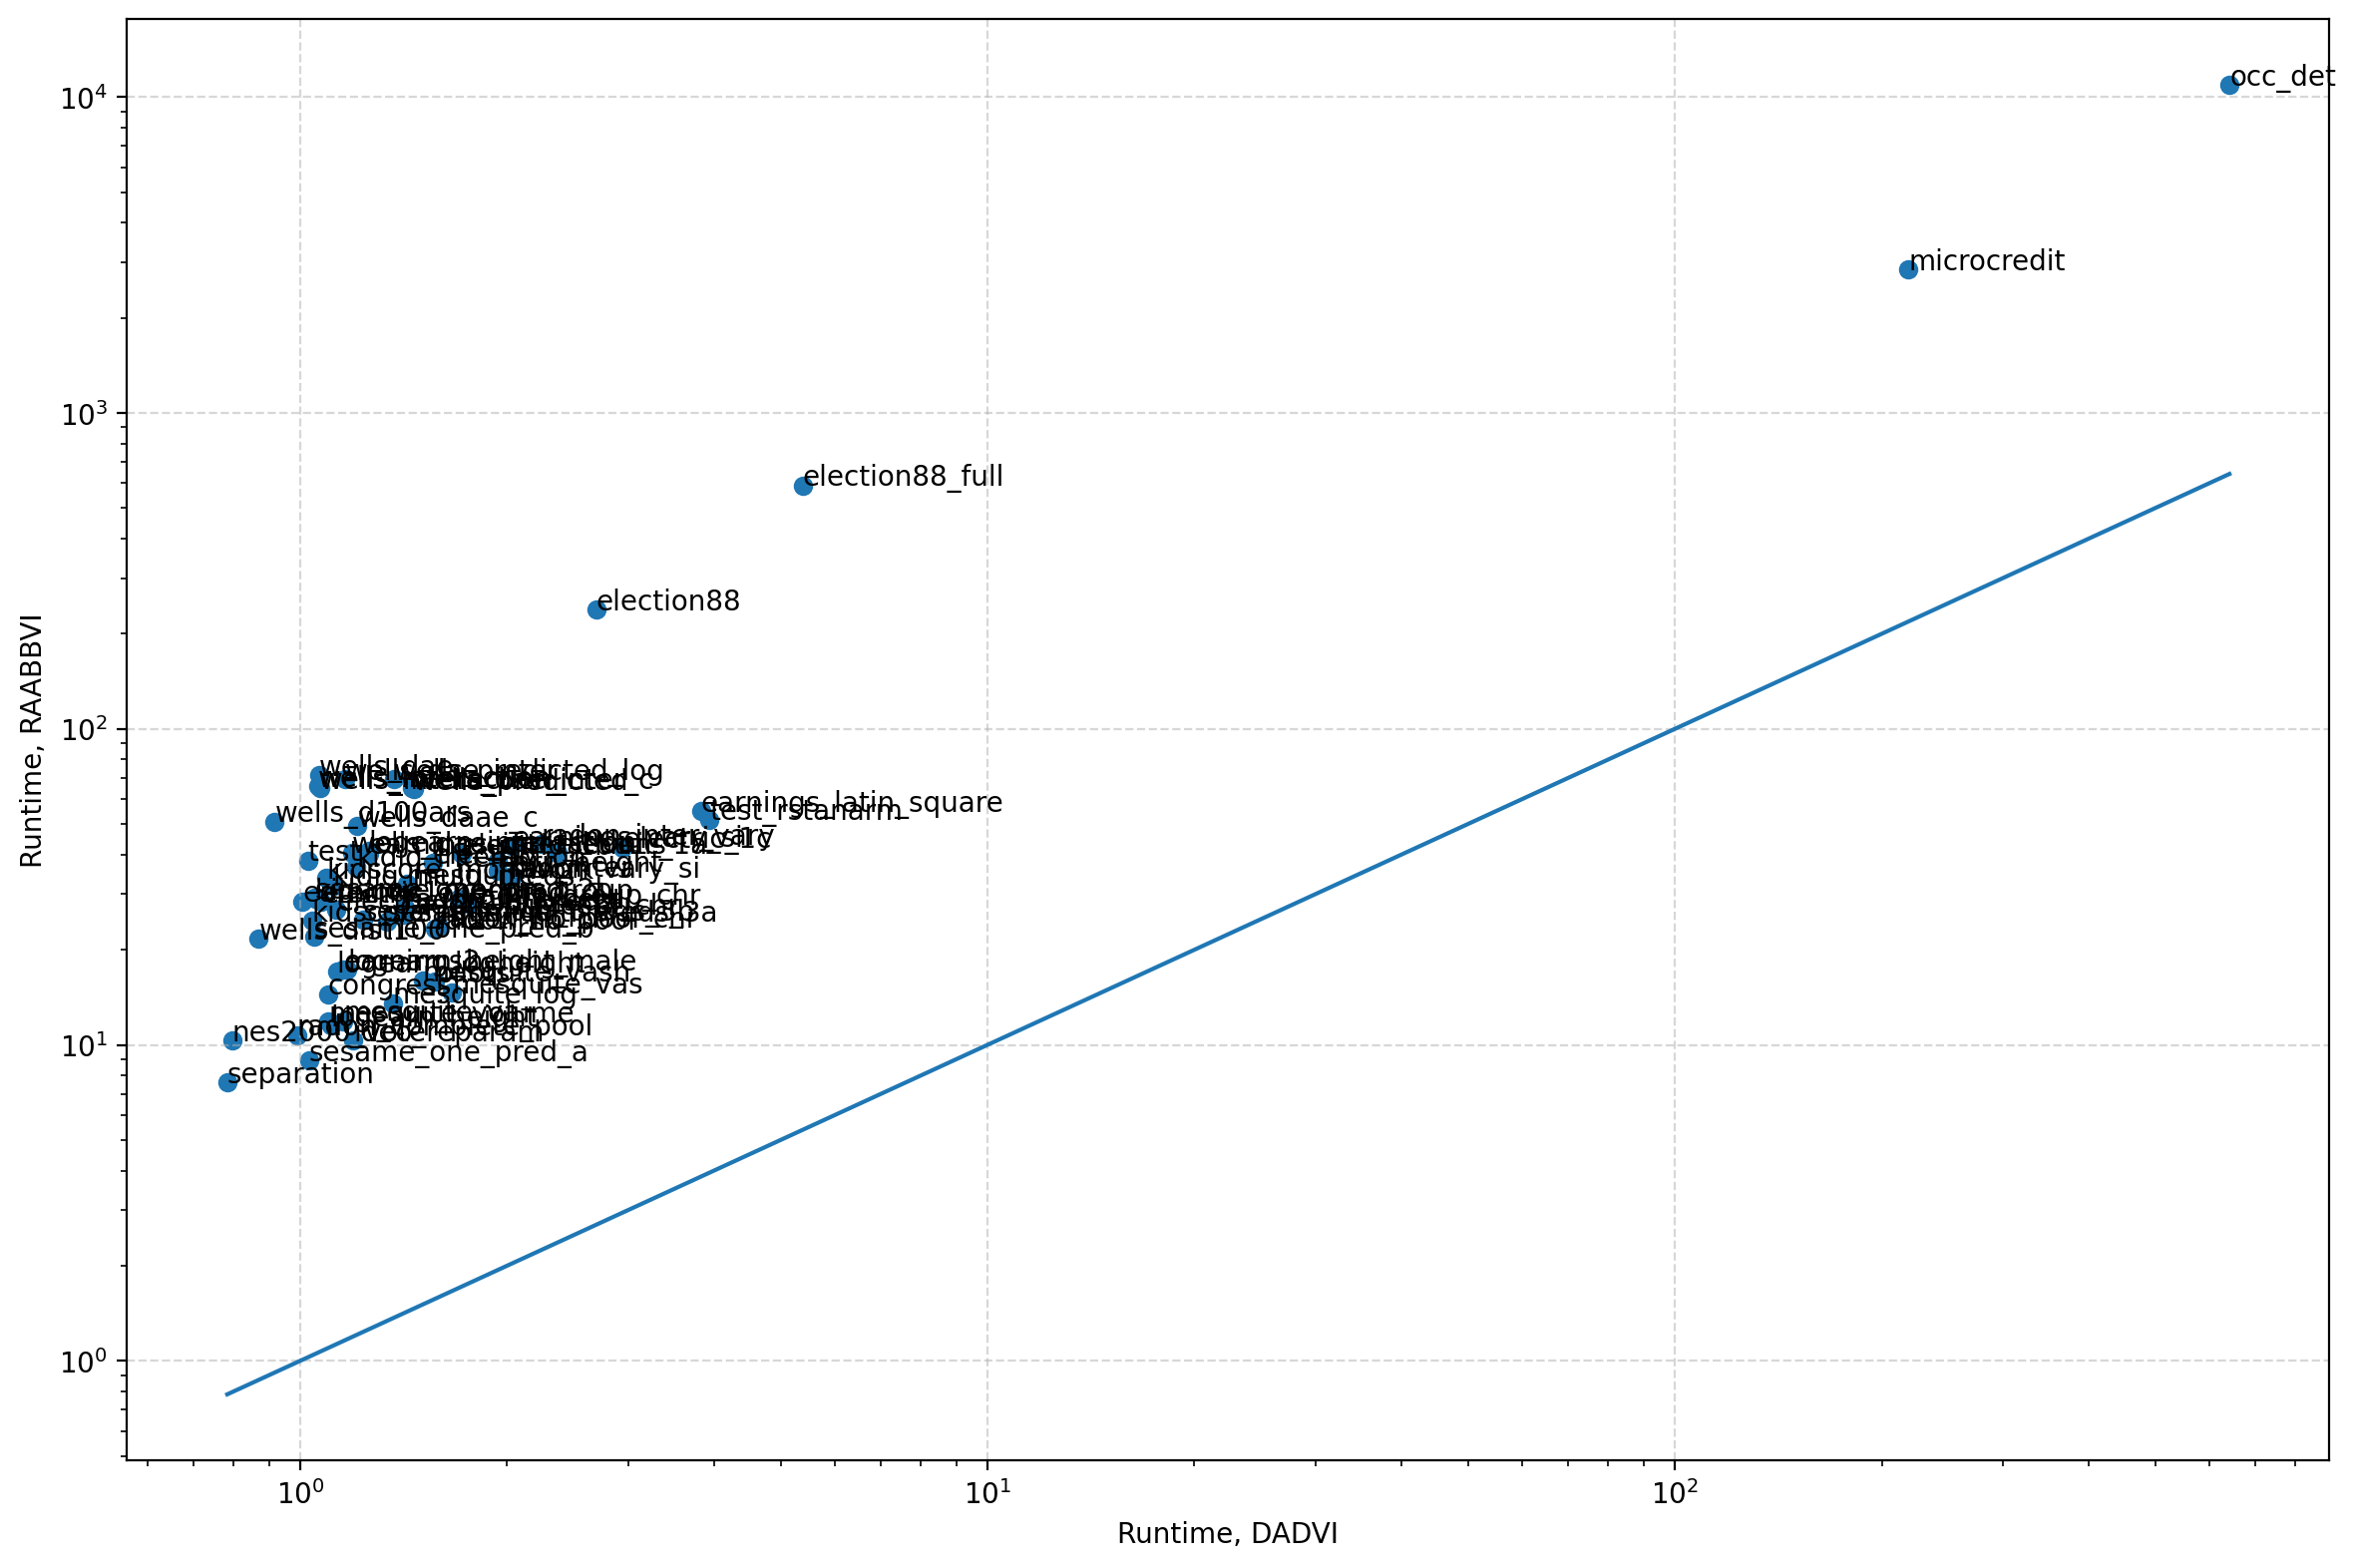

In [23]:

f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison[f'runtime_{method_1}'].min(), comparison[f'runtime_{method_1}'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison[f'runtime_{method_1}'], comparison[f'runtime_{method_2}'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (getattr(row, f'runtime_{method_1}'), getattr(row, f'runtime_{method_2}')))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'Runtime, {method_1}')
ax.set_ylabel(f'Runtime, {method_2}')

ax.grid(alpha=0.5, linestyle='--')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('runtime_comparison.png', dpi=300)

In [24]:
comparison.head()

,draw_dict_path_DADVI,means_DADVI,sds_DADVI,model_name,info_path_DADVI,metadata_DADVI,runtime_DADVI,mean_deviations_DADVI,sd_deviations_DADVI,var_names_DADVI,...,metadata_RAABBVI,runtime_RAABBVI,converged,mean_deviations_RAABBVI,sd_deviations_RAABBVI,var_names_RAABBVI,mean_deviations_flat_RAABBVI,sd_deviations_flat_RAABBVI,mean_rms_RAABBVI,sd_rms_RAABBVI
0,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 0.33795310304035997, 'c_dist100'...","{'Intercept': 0.030490049797417394, 'c_dist100...",wells_dae_inter_c,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [ 0.338753...,1.454596,"{'Intercept': -0.12912341642813885, 'c_dist100...","{'Intercept': -0.19829007443187366, 'c_dist100...","[Intercept, c_arsenic, c_arsenic:c_educ4, c_di...",...,"{'opt_result': [0.34244034420039937, 0.4972047...",64.792155,True,"{'Intercept': -0.030136407180841405, 'c_dist10...","{'Intercept': -0.0063621019357891035, 'c_dist1...","[Intercept, c_arsenic, c_arsenic:c_educ4, c_di...","[-0.030136407180841405, -0.0344771211007467, 0...","[-0.0063621019357891035, -0.039108626219445275...",0.031680,0.047814
1,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 1.2238588397341919, 'x': [-0.592...","{'Intercept': 0.0360937900729387, 'x': [0.0648...",radon_complete_pool,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [ 1.225699...,0.989881,"{'Intercept': -0.028480444707208168, 'x': [0.2...","{'Intercept': 0.3306631893382925, 'x': [-0.107...","[Intercept, x, y_sigma]",...,"{'opt_result': [1.2246182903873999, -0.6135075...",10.743379,True,"{'Intercept': -0.05262309424970235, 'x': [-0.0...","{'Intercept': 0.017319461080812237, 'x': [-0.0...","[Intercept, x, y_sigma]","[-0.05262309424970235, -0.05282731329243913, 0...","[0.017319461080812237, -0.009670925346132654, ...",0.046288,0.013325
2,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 0.14719523070695312, 'black': [-...","{'Intercept': 0.03049705565736079, 'black': [0...",election88_full,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [ 9.628479...,5.383657,"{'Intercept': 0.18494210939749467, 'black': [-...","{'Intercept': -0.9095886954239918, 'black': [-...","[1|age, 1|age_edu, 1|age_edu_offset, 1|age_edu...",...,"{'opt_result': [0.2214337767393307, 1.34836886...",589.771108,False,"{'Intercept': 0.20224792485913157, 'black': [-...","{'Intercept': -0.9411061130269064, 'black': [-...","[1|age, 1|age_edu, 1|age_edu_offset, 1|age_edu...","[-0.5849695793779083, -0.5828058700693367, 0.5...","[-0.9979773925309029, -0.9959047735561799, -0....",0.483358,0.690491
3,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 0.3609467582302399, 'c_dist100':...","{'Intercept': 0.0438726657493569, 'c_dist100':...",wells_interaction_c,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [ 0.359509...,1.067712,"{'Intercept': 0.5692040360039159, 'c_dist100':...","{'Intercept': 0.1350620326338521, 'c_dist100':...","[Intercept, c_arsenic, c_dist100, c_dist100:c_...",...,"{'opt_result': [0.338000134118629, 0.470835724...",65.092864,True,"{'Intercept': -0.006361784242704517, 'c_dist10...","{'Intercept': 0.03270626318315567, 'c_dist100'...","[Intercept, c_arsenic, c_dist100, c_dist100:c_...","[-0.006361784242704517, -0.10261832026345656, ...","[0.03270626318315567, -0.08710444941079848, -0...",0.062757,0.055376
4,/media/martin/External Drive/projects/lrvb_pap...,"{'Intercept': 97.18493078848319, 'treatment': ...","{'Intercept': 0.4192980428127236, 'treatment':...",electric_1b,/media/martin/External Drive/projects/lrvb_pap...,{'opt_result': {'opt_result': {'x': [-2.227039...,1.715874,"{'Intercept': 0.013862321044975017, 'treatment...","{'Intercept': -0.42814149433345, 'treatment': ...","[1|pair, 1|pair_offset, 1|pair_sigma, Intercep...",...,"{'opt_result': [0.9999703086376698, 1.15956376...",40.200612,False,"{'Intercept': -92.94557840902398,

In [25]:
all_results['LRVB_Doubling']['M'] = all_results['LRVB_Doubling']['metadata'].apply(lambda x: x['M'])

In [26]:
all_results['LRVB_Doubling'][['model_name', 'runtime', 'M']].sort_values('M', ascending=False).head(20)

,model_name,runtime,M
37,occ_det,3231.954773,32
41,hiv_inter,3.847775,16
16,electric_1a,4.250730,16
45,microcredit,230.966649,16
44,tennis,1296.632412,16
57,earnings_vary_si,3.405931,16
20,radon_no_pool_chr,2.992355,16
10,earnings_latin_square,8.337828,16
60,radon_inter_vary,4.206867,16
31,radon_no_pool,3.024529,16


In [27]:
all_results['LRVB'][['model_name', 'runtime']].sort_values('runtime')

,model_name,runtime
64,separation,0.768533
9,nes2000_vote,0.794957
17,wells_dist100,0.881234
8,wells_d100ars,0.914805
50,earnings1,0.994757
...,...,...
30,test_rstanarm,4.029059
2,election88_full,6.587784
45,microcredit,253.021683
37,occ_det,1656.722183
